In [1]:
# Import the famous library from Python 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# %cd /kaggle/working
# %cd ../input/celeba-spoof-for-face-antispoofing
# !pwd

In [3]:
def get_ratio_bbox_and_image(full_img_path, bound_box_path):
    img = cv2.imread(full_img_path)
    real_h, real_w, _ = img.shape
    area_image = real_h * real_w
    x1, y1, w1, h1 = get_area_bbox_indices(bound_box_path, real_w, real_h)
    area_bbox = w1*h1
    return area_bbox / area_image


def standard_width_height_scaling(real_w, real_h, bbox0, bbox1, bbox2, bbox3):
    x1 = int(int(bbox0)*(float(real_w) / 224)) # bbox[0]
    y1 = int(int(bbox1)*(float(real_h) / 224)) # bbox[1]
    w1 = int(int(bbox2)*(float(real_w) / 224)) # bbox[2]
    h1 = int(int(bbox3)*(float(real_h) / 224)) # bbox[3]
    return x1, y1, w1, h1


def get_area_bbox_indices(bound_box_path, real_w, real_h):
    bound_box_read = open(bound_box_path, "r")
    bound_box_indices = list()
    for i in bound_box_read:
        bound_box_indices.append(i)
    bbox = bound_box_indices[0].split()
    x1, y1, w1, h1 = standard_width_height_scaling(real_w, real_h, 
                                                   bbox[0], bbox[1], bbox[2], bbox[3])
    return x1, y1, w1, h1

def get_padding_bbox_indices(x1, y1, w1, h1, real_w, real_h, ratio_bbox_and_image):
    x1_padding = x1 - int((w1) * (1+ratio_bbox_and_image))
    y1_padding = y1 - int((h1) * (1+ratio_bbox_and_image))
    w1_padding = w1 + int((w1) * (1+ratio_bbox_and_image))
    h1_padding = h1 + int((h1) * (1+ratio_bbox_and_image))
    if x1_padding < 0: 
        x1_padding = 0
    if y1_padding < 0:
        y1_padding = 0
    if w1_padding > real_w:
        w1_padding = real_w
    if h1_padding > real_h:
        h1_padding = real_h
    return x1_padding, y1_padding, w1_padding, h1_padding
    
def read_crop_img_with_bbox(full_img_path, bound_box_path):
    img = cv2.imread(full_img_path)
#     print(f"bound_box_path: {bound_box_path}")
#     print(f'bound box: {bbox}')
    real_w = img.shape[1]
    real_h = img.shape[0]
#     print(f'read_w = {img.shape[1]}')
#     print(f'read_h = {img.shape[0]}')
    x1, y1, w1, h1 = get_area_bbox_indices(bound_box_path, real_w, real_h)
#     print(f'x1={x1}, y1={y1}, w1={w1}, and h1={h1}')
    return x1, y1, w1, h1, img, real_w, real_h

In [4]:
# Live Storage
original_cropped_storage = []
padding_cropped_storage = []
img_names = []
original_cropped_labels = []
padding_cropped_labels = []

count_live = 0
count_spoof = 0
dim = (32, 32)
count_limit_live = 5000
count_limit_spoof = 5000

rootdir_train = '/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/train'
for file in os.listdir(rootdir_train):
#     file = '1'
    # file is 1, 1000, ..... 10029,...... => Name of folder 
    d = os.path.join(rootdir_train, file)
    if os.path.isdir(d):
        for e in os.listdir(d):
            # e is "live" of "spoof"
            imgs_path = d + '/' + e + '/'
#             print(imgs)
            for img_path in os.listdir(imgs_path):
#                 print(img_path)
#                 imgs_path = '000184.jpg'
                if (img_path.endswith(".jpg")):
                    full_img_path = imgs_path + img_path
#                     print('full_img_path: {full_img_path}')
                    bound_box_path = full_img_path[0:-4] + '_BB.txt'
#                     print(f'bound_box_path: {bound_box_path}')
                    x1, y1, w1, h1, img, real_w, real_h = read_crop_img_with_bbox(full_img_path, bound_box_path)
                    ratio_bbox_and_image = get_ratio_bbox_and_image(full_img_path, bound_box_path)
#                     print(f'ratio_bbox_and_image = {ratio_bbox_and_image}')
                    x1_padding, y1_padding, w1_padding, h1_padding = get_padding_bbox_indices(x1, y1, w1, h1, 
                                                                                              real_w, real_h,
                                                                                              ratio_bbox_and_image)
#                     print(x1_padding, y1_padding, w1_padding, h1_padding)
#                     plt.imshow(img[y1_padding:y1+h1_padding,
#                                    x1_padding:x1+w1_padding])
                    padding_img = img[y1_padding:y1+h1_padding, x1_padding:x1+w1_padding]
                    try:
                        if (e == 'live' and count_live >= count_limit_live) or (e == 'spoof' and count_spoof >= count_limit_spoof):
                            continue
                        resized_padding_img = cv2.resize(padding_img, dim, interpolation = cv2.INTER_AREA)
                        padding_cropped_storage.append(resized_padding_img)
                        if e == 'live':
                            count_live = count_live + 1
                            padding_cropped_labels.append(1)
                        elif e == 'spoof':
                            count_spoof = count_spoof + 1
                            padding_cropped_labels.append(0)
                    except:
                        continue
                        
#                     original_img = img[y1:y1+h1,x1:x1+w1]
#                     try: 
#                         resized_original_img= cv2.resize(original_img, dim, interpolation = cv2.INTER_AREA)
#                         original_cropped_storage.append(resized_original_img)
#                         if e == 'live':
#                             count_live = count_live + 1
#                             original_cropped_labels.append(1)
#                         elif e == 'spoof':
#                             count_spoof = count_spoof + 1
#                             original_cropped_labels.append(0)
#                     except:
#                         continue
                    img_names.append(img_path)

#                     plt.imshow(img)
#                     plt.imshow(img[y1:y1+h1,x1:x1+w1])
#                     print(f'count_live: {count_live}')
#                     print(f'count_spoof: {count_spoof}')
                    if (count_live == count_limit_live and e == 'live') or (count_spoof == count_limit_spoof and e == 'spoof'):
                        break
#                 if count_live == count_limit_live and count_spoof == count_limit_spoof:
#                     break
            if count_live >= count_limit_live and count_spoof >= count_limit_spoof:
                break
    if count_live >= count_limit_live and count_spoof >= count_limit_spoof:
        print("DONE Extracting ")
        break


DONE Extracting 


### Saving the data in the NPZ file

In [5]:
# Save the numpy to NUMPYZ 
X = np.asarray(padding_cropped_storage)
y = np.asarray(padding_cropped_labels)
np.savez('anti_spoofing_data.npz', X, y)
print("DONE SAVING DATA WITH NPZ")

DONE SAVING DATA WITH NPZ


### Checking the number of Live Samples and Spoof Samples after extracting 

In [6]:
anti_spoofing_data = np.load('anti_spoofing_data.npz')
X, y = anti_spoofing_data['arr_0'], anti_spoofing_data['arr_1']
temp = set(y)
check_live_label = 0
check_spoof_label = 0
for i in y: 
    if i == 1:
        check_live_label += 1
    elif i == 0:
        check_spoof_label += 1
print(f"There are 2 classes including number of live is {check_live_label} and number of spoof is {check_spoof_label}")

There are 2 classes including number of live is 5000 and number of spoof is 5000


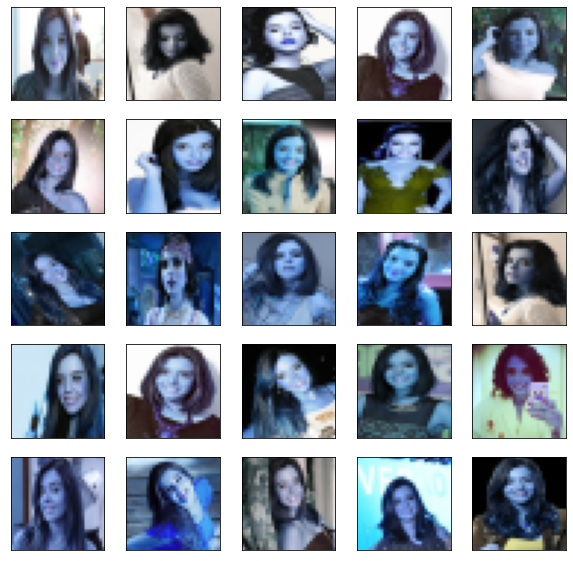

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
#     plt.imshow(original_cropped_storage[i])
    plt.imshow(X[i])
#     plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## SKlearn used for Splitting Training and Testing dataset

In [8]:
from sklearn.model_selection import train_test_split
import numpy as np

# X = np.asarray(padding_cropped_storage)
# y = np.asarray(padding_cropped_labels)
print(X.shape)
print(y.shape)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)
print(f'Training dataset size of X_train: {len(X_train)}')
print(f'Testing dataset size of X_test: {len(X_test)}')
print(f'Validation dataset size of X_valid: {len(X_valid)}')
print(f'Testing dataset size of y_train: {len(y_train)}')
print(f'Testing dataset size of y_test: {len(y_test)}')
print(f'Testing dataset size of y_valid: {len(y_valid)}')

(10000, 32, 32, 3)
(10000,)
Training dataset size of X_train: 7000
Testing dataset size of X_test: 1500
Validation dataset size of X_valid: 1500
Testing dataset size of y_train: 7000
Testing dataset size of y_test: 1500
Testing dataset size of y_valid: 1500


## ===========================================================================================

## Read JSON file 

In [9]:
# rootdir_train_json = '../input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/metas/intra_test/train_label.json'

# patients_df = pd.read_json(rootdir_train_json)
# patients_df.head()
# patients_df.iloc[:,0:19]

### Build a simple CNN Model for training, validating and testing

In [10]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))

model.summary()


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# X_train, X_test, y_train, y_test
history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_valid, y_valid))
model.save("./my_model.h5") 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

47/47 - 0s - loss: 0.1585 - accuracy: 0.9500


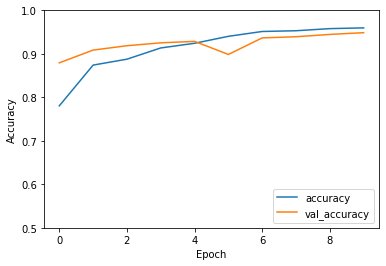

In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)